In [21]:
%pylab inline 
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import jax
import jax_cosmo as jc
import jax.numpy as np
cosmo = jc.Planck15()
from DifferentiableHOS.Plot import plot_contours

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/dl264294/.conda/envs/env_nbody/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cov', 'np']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [31]:
ps_array=[]
jac_array=[]
for i in (range(9)):
    results_dict = pickle.load( open( "/Users/dl264294/Desktop/github/DifferentiableHOS/scripts/file/results"+str(i)+".pkl", "rb" ) )
    ps=results_dict['ps']
    jac=results_dict['jac']
    ps_array.append(ps)
    jac_array.append(jac)
ell=results_dict['ell']

In [32]:
ps_mean=np.mean(np.stack(ps_array),axis=0)
jac_mean=np.mean(np.stack(jac_array),axis=0)

In [33]:
z = linspace(0,2,100)
pz = zeros_like(z)
pz[50] =1. 
nzs_s=jc.redshift.kde_nz(z, pz, bw=0.05)
# let's draw the nz on a new array of redshifts
zsamp = np.linspace(0,2,128)
nzs = [nzs_s]
probes = [ jc.probes.WeakLensing(nzs, sigma_e=0.26) ]
cls = jc.angular_cl.angular_cl(cosmo, ell, probes)


# we compute the covariance matrix using the tools from the Jax module
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, probes,f_sky=25/41252, sparse=True);

/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


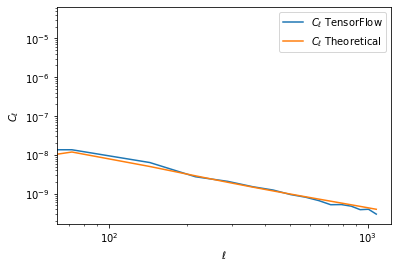

In [34]:
#We compare the theoretical power spectrum with the mean power spectrum obtained from 10 simulations
loglog(ell,  ps_mean, label='$C_{\ell}$ TensorFlow')
loglog(ell, mu, label='$C_{\ell}$ Theoretical')
xlabel('$\ell$')
ylabel('$C_{\ell}$')
legend()

In [35]:
def mean_fn(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
  # Compute signal vector
  m = jc.angular_cl.angular_cl(cosmo, ell, probes)
  return m.flatten()
jac_mean_the = jax.jit(jax.jacfwd(mean_fn))
params = np.array([cosmo.Omega_c, cosmo.sigma8]) 
dmu = jac_mean_the(params)

/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


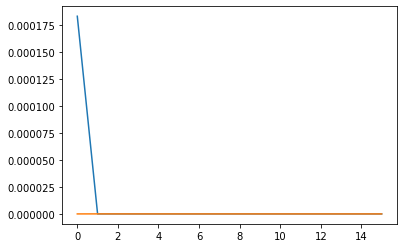

In [36]:
plot(jac_mean[:,0])
plot(dmu[:, 0])

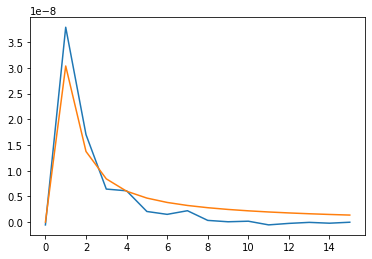

In [37]:
plot(jac_mean[:,1])
plot(dmu[:, 1])

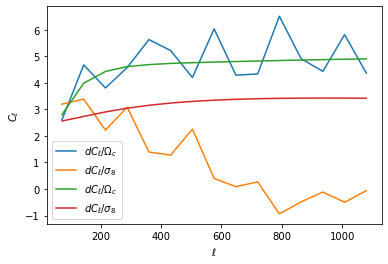

In [41]:

plot(ell, jac_mean[:,0]/mu, label='$dC_{\ell}/ \Omega_c$ ')
plot(ell, jac_mean[:,1]/mu, label='$dC_{\ell}/ \sigma_8$ ')
plot(ell, dmu[:,0]/mu, label='$dC_{\ell}/ \Omega_c$')
plot(ell, dmu[:,1]/mu, label='$dC_{\ell}/ \sigma_8$ ')
xlabel('$\ell$')
ylabel('$C_{\ell}$')
legend()
savefig('psnorm_32.png',dpi=100)

In [39]:
F_1 = jc.sparse.dot(dmu.T, jc.sparse.inv(cov), dmu)

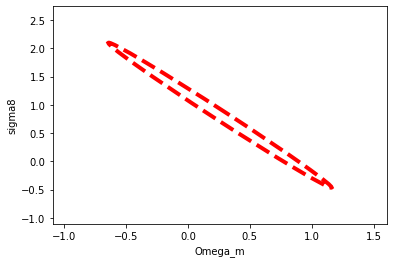

In [40]:
plot_contours(F_1, params, fill=False, color='red', lw=4, linestyle='dashed');
xlabel('Omega_m')
ylabel('sigma8');